# ResNet CIFAR-10 Dataset Classification
* Author: Ziad Tamim
* Description: Training ResNet with CIFAR-10 Dataset. Loading data, building the Lenet achetiture using tensorflow, training the model, and evaluating its performance.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models


2024-04-30 13:48:17.861411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 13:48:17.861500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 13:48:17.976249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading Training and testing data (CIFAR-10)
* Loading the data and splitting it
* Normalising pixle values
* Resize images [64 x 64]

In [2]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Resize images to 64x64 to better fit the model architecture
x_train = tf.image.resize(x_train, [64, 64])
x_test = tf.image.resize(x_test, [64, 64])

# Flatten labels for compatibility with loss function
y_train = y_train.flatten()
y_test = y_test.flatten()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Building the ResNet architechture using tensorflow

In [10]:
def resnet_block(input_layer, filters, conv_size, reduce=False):
    strides = (1, 1)
    if reduce:
        strides = (2, 2)

    # First component of main path
    x = layers.Conv2D(filters, conv_size, padding='same', strides=strides, activation='relu', kernel_initializer='he_normal')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size, padding='same', activation=None, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # Shortcut path
    if reduce:
        input_layer = layers.Conv2D(filters, (1, 1), strides=(2, 2), padding='same', activation=None, kernel_initializer='he_normal')(input_layer)
        input_layer = layers.BatchNormalization()(input_layer)

    x = layers.add([x, input_layer])
    x = layers.Activation('relu')(x)
    return x

def build_resnet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    num_filters = 64
    for stack in range(3):  # Total 3 stacks
        for res_block in range(3):  # 3 res blocks per stack
            x = resnet_block(x, num_filters, (3, 3), reduce=res_block == 0 and stack > 0)
        num_filters *= 2

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile the ResNet model
model = build_resnet((64, 64, 3))
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 16, 16,    │          0 │ add_9[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │     36,928 │ activation_9[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 16, 16,    │          0 │ add_10[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │     36,928 │ activation_10[0]

 Total params: 4,410,634 (16.83 MB)

 Trainable params: 4,404,362 (16.80 MB)

 Non-trainable params: 6,272 (24.50 KB)

# Training the model
* 40 epochs
* 64 batch size

In [11]:
history = model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_test, y_test))


Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.3764 - loss: 1.7542 - val_accuracy: 0.3826 - val_loss: 2.0948
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6042 - loss: 1.1389 - val_accuracy: 0.5930 - val_loss: 1.1917
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6964 - loss: 0.8958 - val_accuracy: 0.6438 - val_loss: 1.0541
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7487 - loss: 0.7580 - val_accuracy: 0.6822 - val_loss: 1.0441
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7907 - loss: 0.6446 - val_accuracy: 0.5638 - val_loss: 1.2534
Epoch 6/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8181 - loss: 0.5553 - val_accuracy: 0.7603 - val_loss: 0.8006
Epoch 7/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8444 - loss: 0.4737 - val_accuracy: 0.5930 - val_loss: 1.3046
Epoch 8/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8669 - loss: 0.4109 - 

In [12]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7942 - loss: 1.1729
Test accuracy: 0.7958999872207642


## Visualising Training Accuracy and Loss

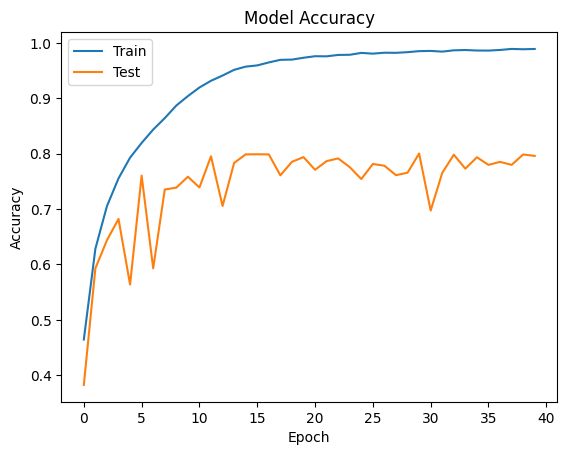

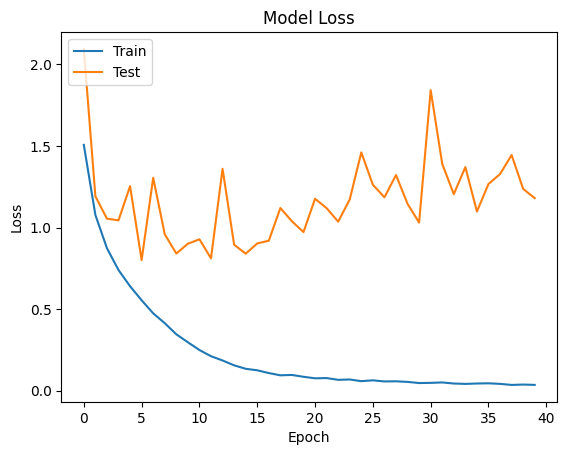

In [13]:
import matplotlib.pyplot as plt
# Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Evaluaing the model using confusion matrix and classification report

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


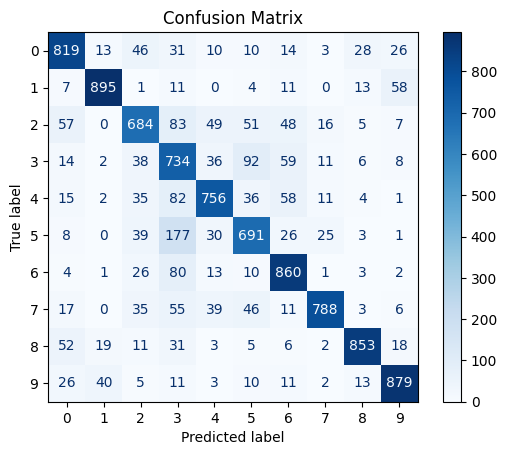

Classification Report:
               precision    recall  f1-score   support

           0     0.8037    0.8190    0.8113      1000
           1     0.9208    0.8950    0.9077      1000
           2     0.7435    0.6840    0.7125      1000
           3     0.5668    0.7340    0.6397      1000
           4     0.8051    0.7560    0.7798      1000
           5     0.7236    0.6910    0.7069      1000
           6     0.7790    0.8600    0.8175      1000
           7     0.9173    0.7880    0.8478      1000
           8     0.9162    0.8530    0.8835      1000
           9     0.8738    0.8790    0.8764      1000

    accuracy                         0.7959     10000
   macro avg     0.8050    0.7959    0.7983     10000
weighted avg     0.8050    0.7959    0.7983     10000



In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# Predictions for the test set
prediction_scores = model.predict(x_test)
predicted_labels = np.argmax(prediction_scores, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_test, predicted_labels, digits=4)
print('Classification Report:\n', report)


## Predicting an image lable from the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step


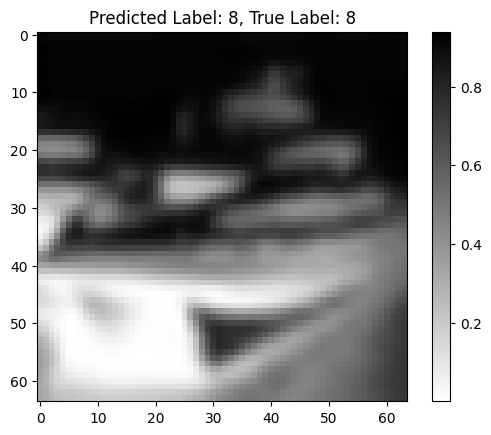

In [15]:
# Inference on a single image
img_index = 1
selected_image = x_test[img_index]
selected_label = y_test[img_index]
image_for_inference = np.expand_dims(selected_image, 0)
predictions = model.predict(image_for_inference)
predicted_label = np.argmax(predictions)

# Display the image
plt.figure()
plt.imshow(selected_image[:, :, 0], cmap=plt.cm.binary)
plt.title(f'Predicted Label: {predicted_label}, True Label: {selected_label}')
plt.colorbar()
plt.grid(False)
plt.show()